# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from matplotlib.cm import Blues
import seaborn as sns
sns.set_theme()
colors = sns.color_palette("deep")
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

# statsmodels
from statsmodels.tsa.stattools import adfuller

# Custom
%load_ext autoreload
%autoreload explicit
%aimport probability_calibration
from probability_calibration import calibrate_proba_monthly_recal

## Parameters

In [40]:
scope = 'BID'
model = 'RF'
extension = '.pkl'
cal = '' # _CALIBRATED

input_path = f'/Users/guillaume/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Share/asm_forecast/ML_dataset_{scope}.pkl'
predictions_path = f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m{cal}{extension}'
cal_save_folder = f'{scope}/model_dumps/calibrator'

start_month = 202001
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [41]:
def AUCPR(groupby):
    return average_precision_score(groupby[target], groupby['y_probs'])

def Precision(groupby):
    return precision_score(groupby[target], (groupby['y_probs'] >= 0.5))

def Recall(groupby):
    return recall_score(groupby[target], (groupby['y_probs'] >= 0.5))

def F1(groupby):
    return f1_score(groupby[target], (groupby['y_probs'] >= 0.5))

In [42]:
def get_score_per_group(
        df,
        group,
        score=AUCPR,
        plot=True,
        plot_kind='bar',
        plot_trend=False,
        hide_xlab=True,
        plot_baseline=False,
        ylab=None,
        **kwargs
    ):
    score_df = df.groupby(group, as_index=False).apply(score).rename({None: score.__name__}, axis=1)
    score_df.sort_values(group, inplace=True)
    score_df[group[0]] = score_df[group[0]].astype(str)
    if plot:
        fig, ax = plt.subplots()
        if len(group) > 1:
            score_df.pivot(index=group[0], columns=group[1], values=score.__name__).plot(kind='bar', ax=ax, **kwargs)
        else:
            score_df.set_index(group[0]).plot(kind=plot_kind, legend=False, ax=ax, **kwargs)
        if plot_trend:
            mean_score = score_df[score.__name__].mean()
            ax.axhline(y=mean_score, linestyle='--', color='red', linewidth=1)
            # Add annotation for correlation coefficient
            ax.annotate('$\mu = {:.2f}$'.format(mean_score), xy=(0.78, 0.81), xycoords='axes fraction',  
            xytext=(20, 20), textcoords='offset points',  fontsize=14, color='red')
        if plot_baseline:
            ax1 = ax.twinx()
            rate_df = df.groupby(group, as_index=False)["Result"].mean()
            rate_df[group[0]] = rate_df[group[0]].astype(str)
            ax1.plot(rate_df[group[0]], rate_df.Result, color='black', linewidth=1, markersize=3, label='Prior probability')
            ax1.set_ylabel('Prior probability')
            ax1.set_ylim((0, 0.06))
            ax.grid(False)
            ax1.grid(False)
        if hide_xlab:
            plt.xlabel(None)
        plt.xticks(rotation=0)
        if ylab:
            plt.ylabel(ylab)
        else:
            plt.ylabel(score.__name__)
        # plt.ylim((0,1))
        ax.set_ylim((0, 1))
        # plt.title('{} bids APS per {}'.format(scope, group[0]))
        # plt.tight_layout()
        plt.savefig('../plots/{}/precision_recall/{}_{}_{}_{}.png'.format(scope, model, score.__name__, '_'.join(group), scope.lower()), bbox_inches='tight')
        plt.show()

    return score_df

In [43]:
def get_acc_rate_per_group(df, group, plot=True, **kwargs):
    rate_df = df.groupby(group, as_index=False)["Result"].mean()
    rate_df[group[0]] = rate_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            rate_df.pivot(index=group[0], columns=group[1], values="Result").plot(kind='bar', **kwargs)
        else:
            rate_df.set_index(group[0]).plot(kind='bar', legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Acceptance rate')
        plt.title('{} bids acceptance rate per {}'.format(scope, group[0]))
        plt.tight_layout()
        plt.savefig('../plots/{}/{}_acc_{}_{}.png'.format(scope, model, '_'.join(group), scope.lower()))
        plt.show()

    return rate_df

# Main

## Load dataset & model predictions

In [44]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df['Month'] = pd.PeriodIndex(year=df['year'], month=df['month'], freq='M')
# df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty,yearmonth,month,Month
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,0.095,0.095,26.22,-0.349,False,0.000000,22.000,201801,1,2018-01
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,0.095,0.095,26.22,-0.329,False,0.000000,22.000,201801,1,2018-01
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,0.095,0.095,26.22,-0.324,False,0.000000,22.000,201801,1,2018-01
2018010117UP_ARSIE_1_BID,17,20180101,2018,UP_ARSIE_1,BID,3.456008,0.661794,-2.372137,-0.624680,3.037220,...,0.627,0.627,0.00,-1.000,False,0.000000,15.800,201801,1,2018-01
2018010118UP_ARSIE_1_BID,18,20180101,2018,UP_ARSIE_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,1.000,1.000,0.00,-1.000,False,0.000000,27.000,201801,1,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,17,20221231,2022,UP_VOGHERA_1,BID,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,0.540,0.540,135.00,-0.350,False,0.000000,4.491,202212,12,2022-12
2022123118UP_VOGHERA_1_BID,18,20221231,2022,UP_VOGHERA_1,BID,0.055686,-2.259989,-1.329127,0.607693,-2.561474,...,1.000,1.000,136.00,-0.420,True,0.222876,186.000,202212,12,2022-12
2022123119UP_VOGHERA_1_BID,19,20221231,2022,UP_VOGHERA_1,BID,-0.051126,-2.357014,-1.293692,0.548271,-2.484197,...,1.000,1.000,138.00,-0.414,True,0.244465,187.000,202212,12,2022-12
2022123120UP_VOGHERA_1_BID,20,20221231,2022,UP_VOGHERA_1,BID,-0.029177,-2.330178,-1.385200,0.630366,-2.484197,...,1.000,1.000,141.00,-0.405,True,0.176471,187.000,202212,12,2022-12


In [45]:
# Load model predictions
if cal == '_CALIBRATED':
    probs = 'y_probs_cal'
    print("Get calibrated probabilities")
else:
    probs = 'y_probs'
    print("Get raw probabilities")
if predictions_path.endswith('.csv'):
    y_probs = pd.read_csv(predictions_path, index_col=0)[probs]
else:
    y_probs = pd.read_pickle(predictions_path)
y_probs
# Below some obs could be dropped as NA as they were not in the prediction process
df['y_probs'] = y_probs
# We drop them
print(len(df))
# df.dropna(subset=['y_probs'], inplace=True)
print(len(df))

Get raw probabilities
2177292
2177292


## Calibration curves

In [46]:
test_df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
test_df['y_probs_cal'] = calibrate_proba_monthly_recal(df, start_month, end_month, save_folder=cal_save_folder)
# Sometimes the isotonic regression creates na so in this case we simply take the uncalibrated y
cal_is_na = test_df.y_probs_cal.isna()
test_df.loc[cal_is_na, 'y_probs_cal'] = test_df.loc[cal_is_na, 'y_probs']
print(f"{cal_is_na.sum()} observations have a NaN calibrated value. For these observations, y_probs_cal was set to y_probs.")

100%|██████████| 36/36 [00:02<00:00, 12.75it/s]


6 observations have a NaN calibrated value. For these observations, y_probs_cal was set to y_probs.


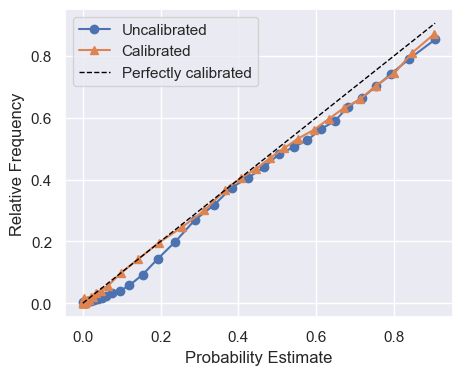

In [47]:
n_bins = 50
plt.figure(figsize=(5,4))
prob_true, prob_pred = calibration_curve(test_df.Result, test_df.y_probs, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', color=colors[0])

prob_true_cal, prob_pred_cal = calibration_curve(test_df.Result, test_df.y_probs_cal, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Probability Estimate')
plt.ylabel('Relative Frequency')
plt.legend()

plt.savefig(f"../plots/{scope}/rd_{scope}.png", bbox_inches='tight') 

In [11]:
test_df.y_probs_cal.to_pickle(f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m_CALIBRATED{extension}')

## Performance analysis

### Overall performance per year

In [30]:
df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]

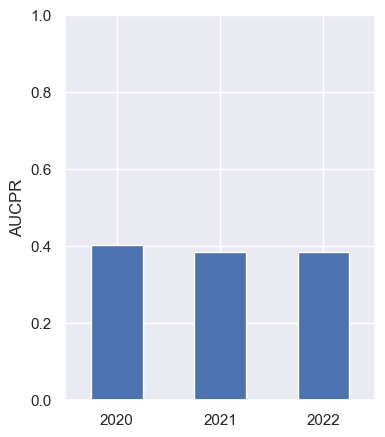

In [48]:
aps_df = get_score_per_group(df, group=['year'], figsize=(4,5))

In [53]:
aps_df

,year,AUCPR
0,2019,0.325270
1,2020,0.407729
2,2021,0.388073
3,2022,0.389153


### Overall performance per hour

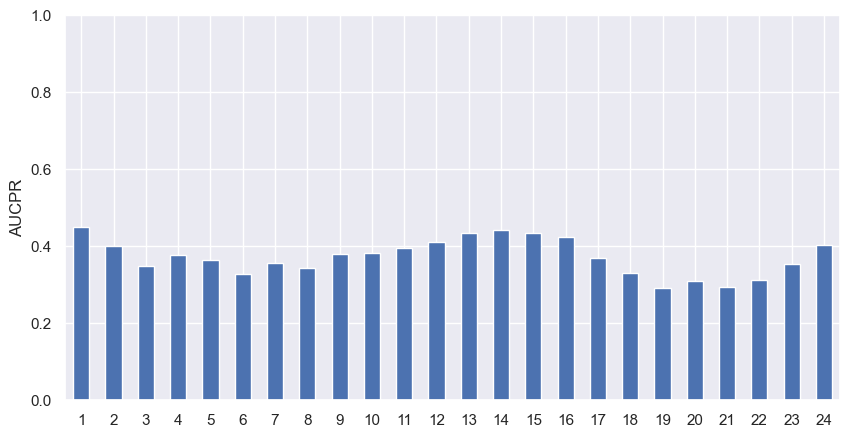

,hour,AUCPR
0,1,0.447970
1,2,0.398410
2,3,0.347846
3,4,0.376923
4,5,0.363770
5,6,0.326264
6,7,0.355111
7,8,0.342708
8,9,0.377581
9,10,0.380210


In [54]:
aps_df = get_score_per_group(df, group=['hour'], figsize=(10,5))
aps_df

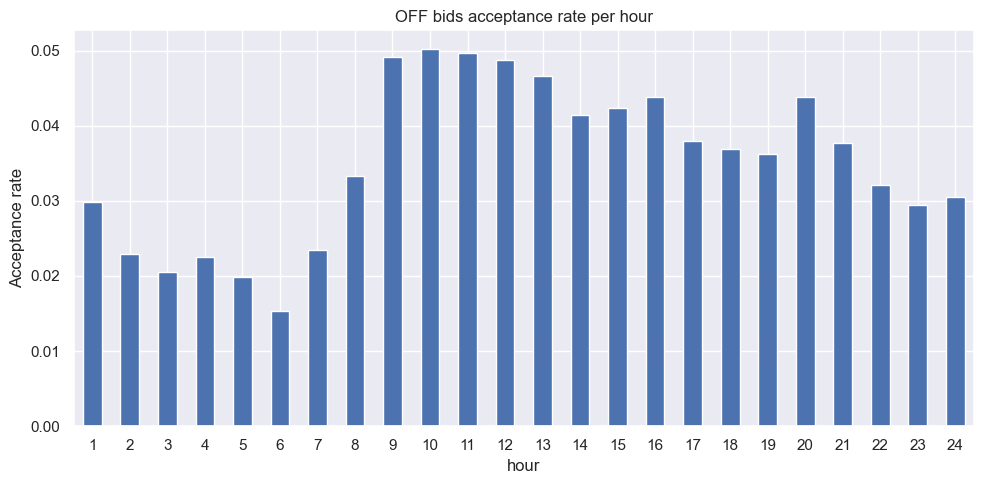

,hour,Result
0,1,0.029885
1,2,0.022915
2,3,0.020489
3,4,0.022537
4,5,0.019896
5,6,0.015401
6,7,0.023426
7,8,0.033341
8,9,0.049176
9,10,0.050177


In [55]:
acc_df = get_acc_rate_per_group(df, ["hour"], figsize=(10,5))
acc_df

So it seems that it is the acceptance rate is not really driving the variability in the performance of the model

### Overall performance per month

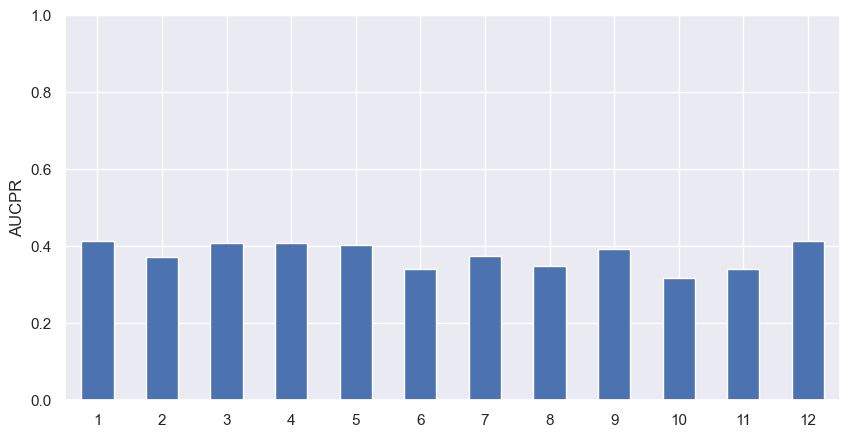

,month,AUCPR
0,1,0.412551
1,2,0.370314
2,3,0.407609
3,4,0.407720
4,5,0.401288
5,6,0.340147
6,7,0.372658
7,8,0.348307
8,9,0.392135
9,10,0.316171


In [56]:
aps_df = get_score_per_group(df, group=['month'], figsize=(10,5))
aps_df

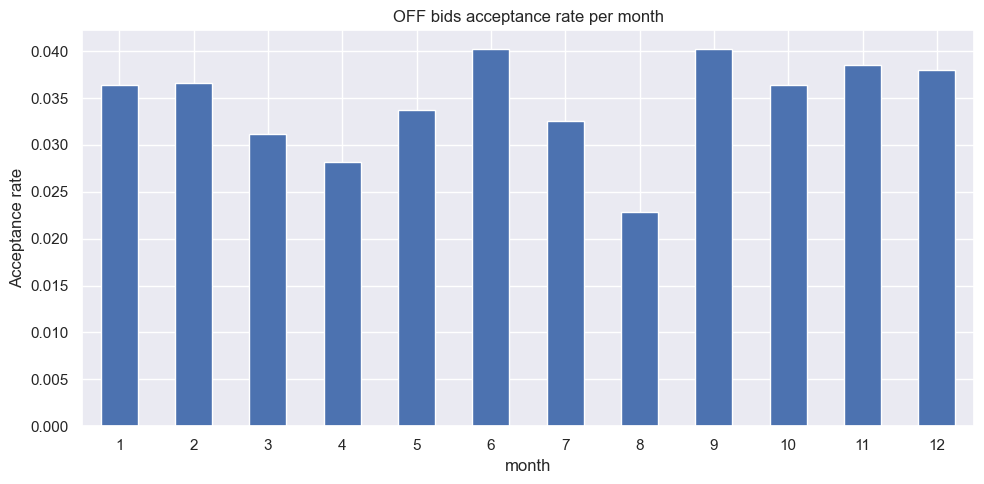

,month,Result
0,1,0.036406
1,2,0.036605
2,3,0.031193
3,4,0.028153
4,5,0.033721
5,6,0.040205
6,7,0.032513
7,8,0.022800
8,9,0.040181
9,10,0.036401


In [57]:
acc_df = get_acc_rate_per_group(df, ["month"], figsize=(10,5))
acc_df

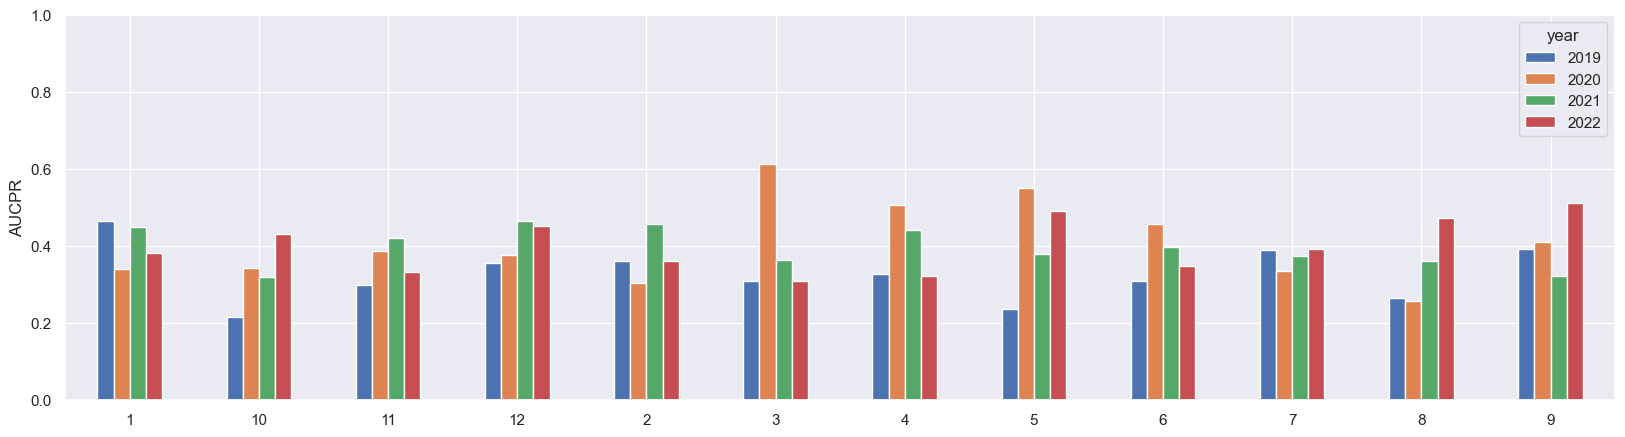

In [58]:
aps_df = get_score_per_group(df, group=['month', 'year'], figsize=(20,5))

### Overall performance per technology

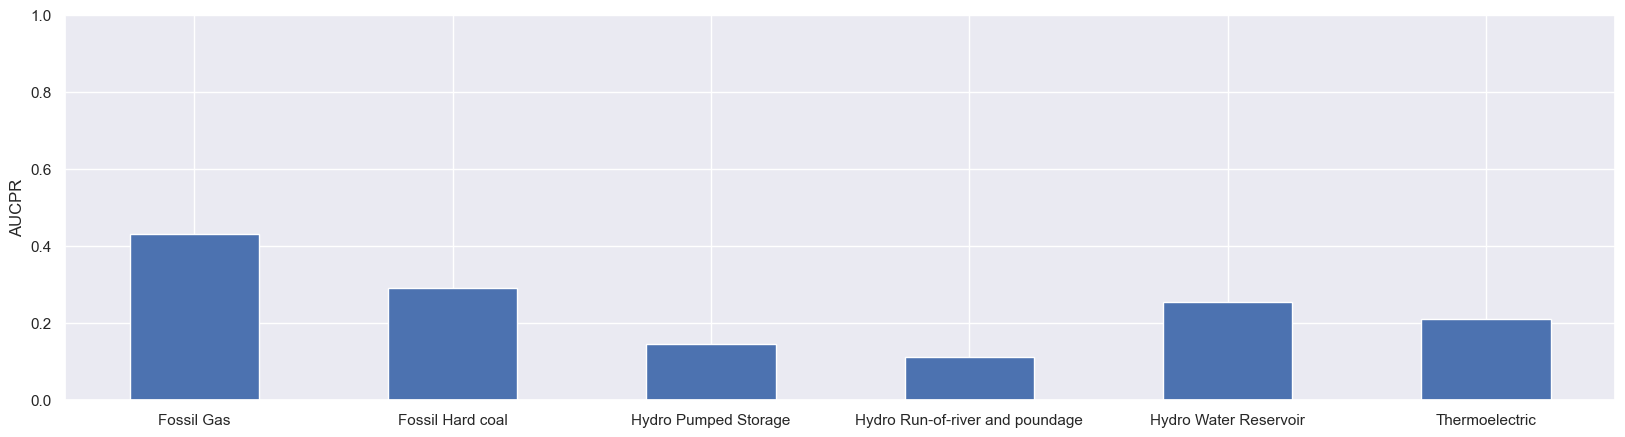

,Tech,AUCPR
0,Fossil Gas,0.431249
1,Fossil Hard coal,0.291662
2,Hydro Pumped Storage,0.146038
3,Hydro Run-of-river and poundage,0.111623
4,Hydro Water Reservoir,0.253970
5,Thermoelectric,0.210002


In [59]:
aps_df = get_score_per_group(df, group=['Tech'], figsize=(20,5))
aps_df

In [60]:
df.Tech.value_counts()

Tech
Fossil Gas                         817752
Hydro Water Reservoir              787059
Hydro Pumped Storage               503674
Hydro Run-of-river and poundage    329261
Thermoelectric                     171779
Fossil Hard coal                   154974
Name: count, dtype: int64

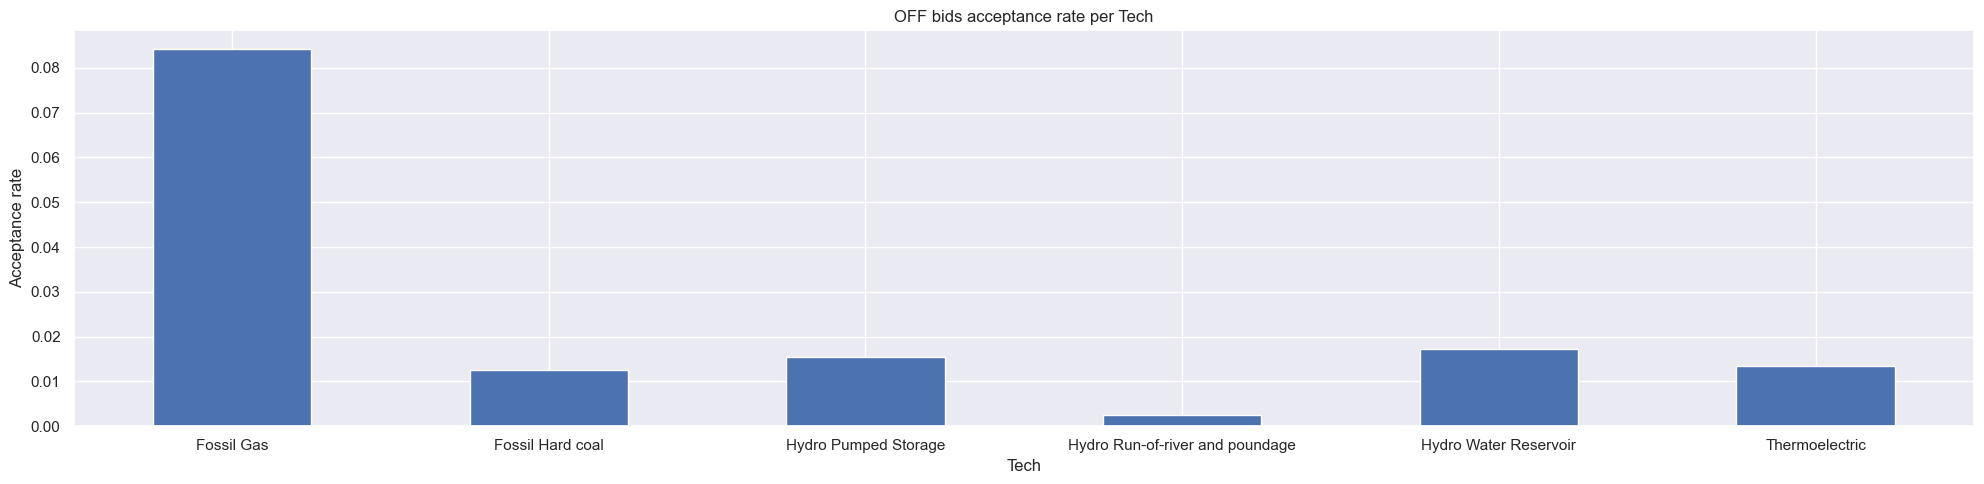

In [61]:
acc_df = get_acc_rate_per_group(df, ["Tech"], figsize=(20,5))

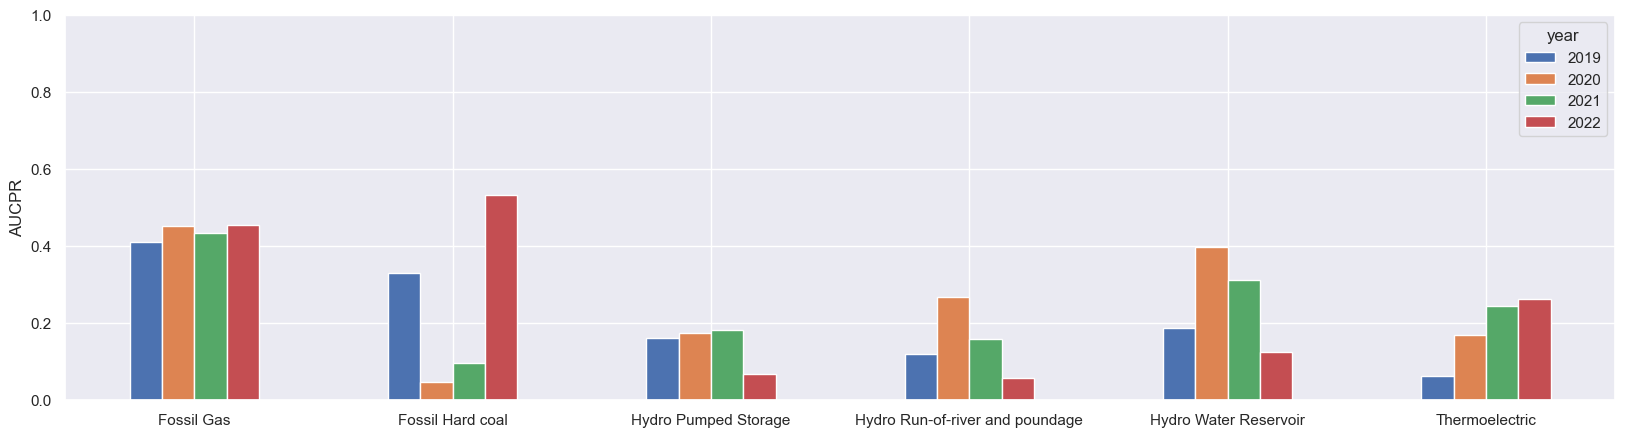

In [62]:
aps_df = get_score_per_group(df, group=['Tech', 'year'], figsize=(20,5))

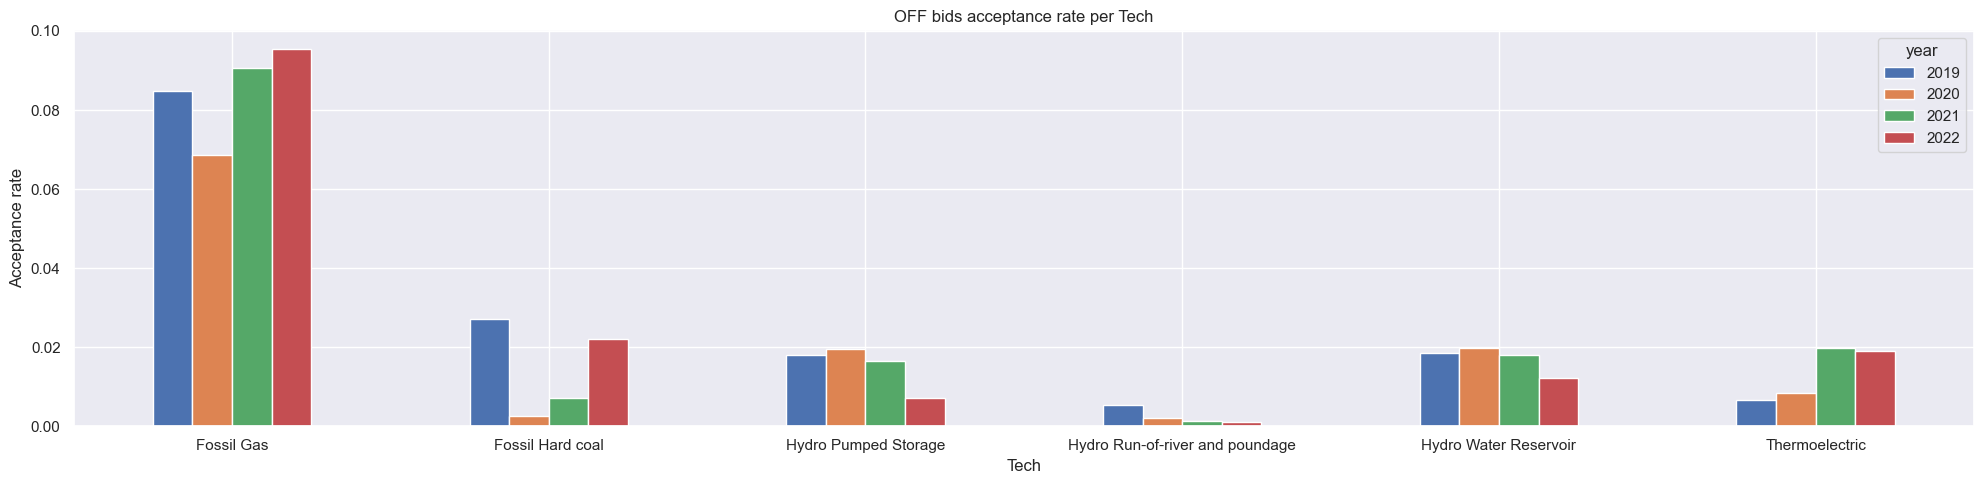

In [63]:
acc_df = get_acc_rate_per_group(df, ["Tech", "year"], figsize=(20,5))

### Time series of monthly performance

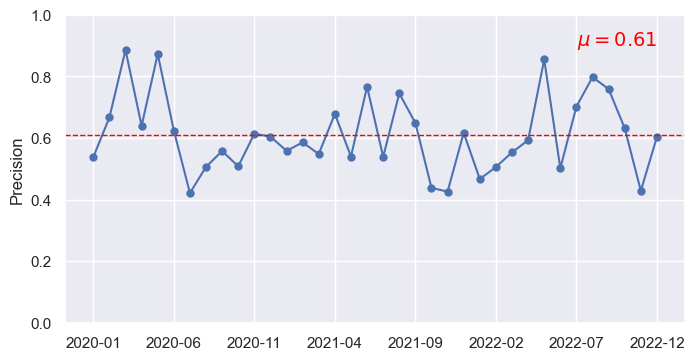

In [31]:
precision_df = get_score_per_group(df, score=Precision, group=['Month'], plot_kind='line', figsize=(8,4), marker='o', markersize=5, plot_trend=True)

In [137]:
adfuller(precision_df.Precision)

(-1.6136720439586032,
 0.47604832213768233,
 7,
 28,
 {'1%': -3.6889256286443146,
  '5%': -2.9719894897959187,
  '10%': -2.6252957653061224},
 -53.5816115817548)

array([[<Axes: title={'center': 'Precision'}>]], dtype=object)

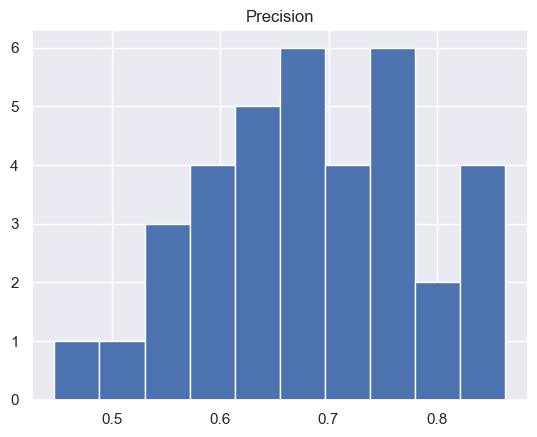

In [138]:
precision_df.hist()

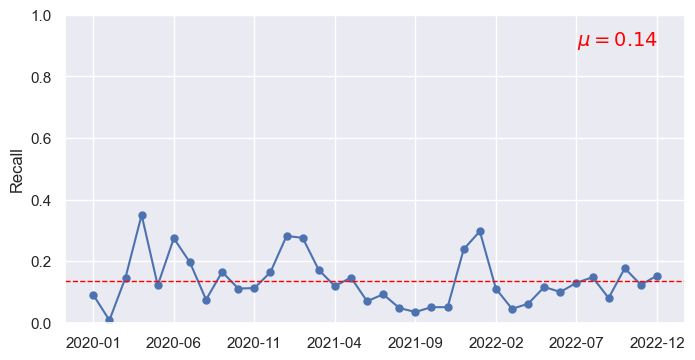

In [32]:
recall_df = get_score_per_group(df, score=Recall, group=['Month'], plot_kind='line', plot_trend=True, figsize=(8,4), marker='o', markersize=5)

In [140]:
adfuller(recall_df.Recall)

(0.44891407937495703,
 0.9832348235591148,
 2,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 -45.52632459415645)

array([[<Axes: title={'center': 'Recall'}>]], dtype=object)

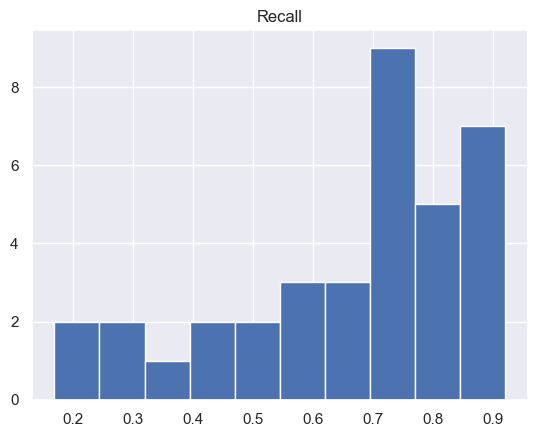

In [141]:
recall_df.hist()

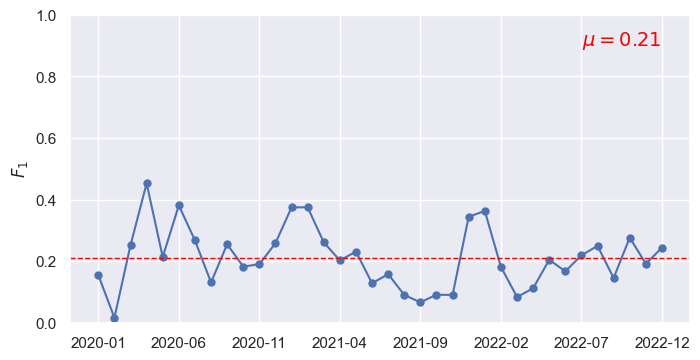

In [33]:
f1_df = get_score_per_group(df, score=F1, group=['Month'], plot_kind='line', figsize=(8,4), plot_trend=True, ylab='$F_1$', marker='o', markersize=5)

In [143]:
adfuller(f1_df.F1)

(0.7120587603442056,
 0.9900754758203479,
 6,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 -55.24026972581103)

array([[<Axes: title={'center': 'F1'}>]], dtype=object)

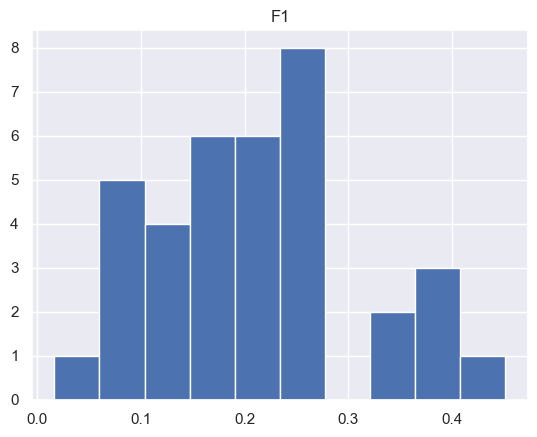

In [114]:
f1_df.hist()

In [ ]:
input_df.to_csv(input_path.replace('.pkl', '.csv'))

<HR>

# TESTS

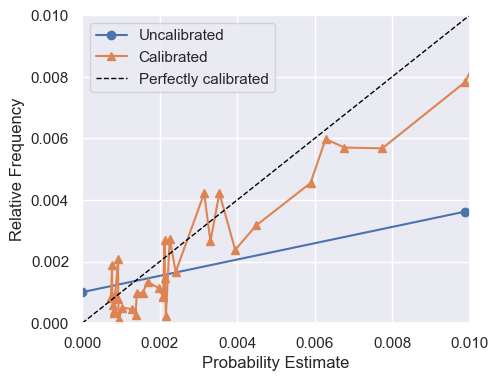

In [11]:
n_bins = 50
plt.figure(figsize=(5,4))
prob_true, prob_pred = calibration_curve(test_df.Result, test_df.y_probs, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', color=colors[0])

prob_true_cal, prob_pred_cal = calibration_curve(test_df.Result, test_df.y_probs_cal, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Probability Estimate')
plt.ylabel('Relative Frequency')
plt.xlim((0, 0.01))
plt.ylim((0, 0.01))
plt.legend()

In [23]:
test_df.y_probs_cal.quantile(np.linspace(0,1,21))

0.00    0.000734
0.05    0.000776
0.10    0.000809
0.15    0.000844
0.20    0.000931
0.25    0.001272
0.30    0.001409
0.35    0.001776
0.40    0.002093
0.45    0.002135
0.50    0.002413
0.55    0.003405
0.60    0.004717
0.65    0.006599
0.70    0.010828
0.75    0.015348
0.80    0.026894
0.85    0.050378
0.90    0.102664
0.95    0.236941
1.00    1.000000
Name: y_probs_cal, dtype: float64

In [29]:
prob_true_cal

array([8.53015885e-04, 1.89948037e-03, 8.16875691e-04, 5.78779336e-04,
       4.05619676e-04, 3.38264478e-04, 8.43128503e-04, 9.55060082e-04,
       2.08204812e-03, 7.71724031e-04, 1.19750918e-04, 5.07687845e-04,
       4.54736253e-04, 2.50281567e-04, 9.81836033e-04, 9.90344145e-04,
       1.33997229e-03, 1.12769237e-03, 8.39405030e-04, 8.91358281e-04,
       2.68535019e-03, 1.45521181e-03, 2.36106602e-04, 2.73489193e-03,
       1.66221950e-03, 4.21354416e-03, 2.65836245e-03, 4.22084732e-03,
       2.38241829e-03, 3.17117117e-03, 4.55187569e-03, 5.97914711e-03,
       5.70146743e-03, 5.67638623e-03, 7.83061922e-03, 1.15175294e-02,
       9.74406260e-03, 1.52939961e-02, 1.63215959e-02, 2.08125871e-02,
       2.41689559e-02, 3.46427311e-02, 4.32575758e-02, 5.95479462e-02,
       7.94010318e-02, 1.15519371e-01, 1.62699912e-01, 2.23467900e-01,
       3.17802783e-01, 4.94140477e-01])

In [30]:
prob_pred_cal

array([0.00074281, 0.00077094, 0.00077563, 0.00079789, 0.00080947,
       0.00082967, 0.00083898, 0.00085441, 0.00092609, 0.00093027,
       0.00094692, 0.00103027, 0.00127242, 0.00137619, 0.00140914,
       0.00156066, 0.00169012, 0.00199417, 0.00208093, 0.00208935,
       0.00212519, 0.0021349 , 0.00215943, 0.00225853, 0.00241286,
       0.003147  , 0.00330924, 0.00354042, 0.00394804, 0.00448809,
       0.00589367, 0.00628037, 0.00676837, 0.00774321, 0.00988334,
       0.01129946, 0.01263754, 0.01544206, 0.01930691, 0.02337974,
       0.02945154, 0.03909961, 0.0506822 , 0.06891363, 0.09047073,
       0.12497677, 0.17343494, 0.24012611, 0.33133809, 0.50642247])

In [22]:
df['y_probs'].max()

0.92

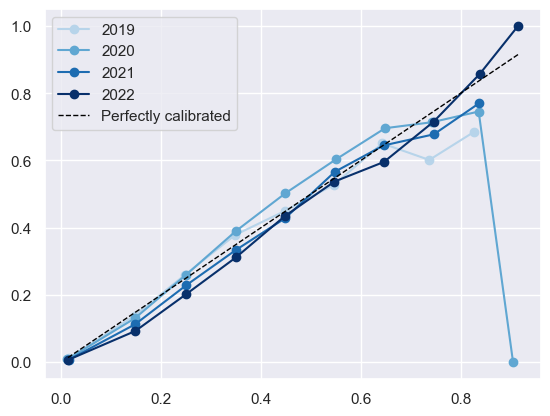

In [80]:
n_bins = 10
cmap = [Blues(value) for value in np.linspace(0.3, 1, 4)]
for k, year in enumerate(df.year.unique()):
    prob_true, prob_pred = calibration_curve(df[df.year == year].Result, df[df.year == year].y_probs, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o', label=year, color=cmap[k])
plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)
plt.legend()

In [1]:
n_bins = 10
year = 2021

prob_true, prob_pred = calibration_curve(df[df.year == year].Result, df[df.year == year].y_probs, n_bins=n_bins)
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', color=colors[0])

# prob_true, prob_pred = calibration_curve(df[df.year == year].Result, df[df.year == year].y_probs_cal, n_bins=n_bins)
# plt.plot(prob_pred, prob_true, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Average predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()

NameError: name 'calibration_curve' is not defined